In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(0)
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class JANet(nn.Module):
    
    def __init__(self, inputs, cells, num_outputs, num_timesteps, output_activation=None):
        super(JANet, self).__init__()
        
        self.inputs = inputs
        self.cells = cells
        self.classes = num_outputs
        self.num_timesteps = num_timesteps
        self.output_activation = output_activation
        
        kernel_data = torch.zeros(inputs, 2 * cells, dtype=torch.get_default_dtype())
        kernel_data = torch.nn.init.xavier_uniform_(kernel_data)
        self.kernel = nn.Parameter(kernel_data)
        
        recurrent_kernel_data = torch.zeros(cells, 2 * cells, dtype=torch.get_default_dtype())
        recurrent_kernel_data = torch.nn.init.xavier_uniform_(recurrent_kernel_data)
        self.recurrent_kernel = nn.Parameter(recurrent_kernel_data)
        
        recurrent_bias = np.zeros(2 * cells)
        # chrono initializer
        recurrent_bias[:cells] = np.log(np.random.uniform(1., self.num_timesteps - 1, size=cells))
        recurrent_bias = recurrent_bias.astype('float32')
        self.recurrent_bias = nn.Parameter(torch.from_numpy(recurrent_bias))
        
        self.output_dense = nn.Linear(cells, num_outputs)
        
    def forward(self, inputs):
        h_state = torch.zeros(inputs.size(0), self.cells, dtype=torch.get_default_dtype()).to(device)
        c_state = torch.zeros(inputs.size(0), self.cells, dtype=torch.get_default_dtype()).to(device)
        
        num_timesteps = inputs.size(1)
        
        for t in range(num_timesteps):
            ip = inputs[:, t, :]
            
            z = torch.mm(ip, self.kernel)
            z += torch.mm(h_state, self.recurrent_kernel) + self.recurrent_bias
            
            z0 = z[:, :self.cells]
            z1 = z[:, self.cells: self.cells * 2]
            
            f = F.sigmoid(z0)
            c = f * c_state + (1. - f) * F.tanh(z1)
            
            h = c
            
            h_state = h
            c_state = c
        
        preds = self.output_dense(h_state)
        
        if self.output_activation is not None:
            preds = self.output_activation(preds)
        
        return preds


In [4]:
# we define some constants 
import os
import shutil
if not os.path.exists('weights'):
    os.makedirs('weights/')

# Parameters taken from https://arxiv.org/abs/1804.04849
TIME_STEPS = 100
NUM_UNITS = 128
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 100
NUM_EPOCHS = 10
BATCH_SIZE = 50


CHECKPOINTS_DIR = 'checkpoints_addition_pytorch/'
CHECKPOINT_PATH = CHECKPOINTS_DIR + 'addition_janet.pkl'

if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

In [5]:
# Code reused from https://github.com/batzner/indrnn/blob/master/examples/addition_rnn.py
# with some modifications to run on Tensorflow Eager mode
def batch_generator():
    while True:
        """Generate the adding problem dataset"""
        # Build the first sequence
        add_values = np.random.rand(BATCH_SIZE, TIME_STEPS)

        # Build the second sequence with one 1 in each half and 0s otherwise
        add_indices = np.zeros_like(add_values, dtype='float32')
        half = int(TIME_STEPS / 2)
        for i in range(BATCH_SIZE):
            first_half = np.random.randint(half)
            second_half = np.random.randint(half, TIME_STEPS)
            add_indices[i, [first_half, second_half]] = 1.

        # Zip the values and indices in a third dimension:
        # inputs has the shape (batch_size, time_steps, 2)
        inputs = np.dstack((add_values, add_indices))
        targets = np.sum(np.multiply(add_values, add_indices), axis=1)
        targets = np.expand_dims(targets, -1)

        # center at zero mean
        inputs -= np.mean(inputs, axis=0, keepdims=True)
        
        inputs = inputs.astype('float32')
        targets = targets.astype('float32')

        yield inputs, targets

In [7]:
model = JANet(inputs=2, cells=NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS)

In [8]:
loss_fn = nn.MSELoss().to(device)
optimizer = optim.Adam(list(model.parameters()), lr=LEARNING_RATE)

In [10]:
%%time
model = model.to(device)

best_loss = 100.
generator = batch_generator()

loss_history = []
update_counter = 1

for epoch in range(NUM_EPOCHS):
    print("Epoch # : ", epoch + 1)

    for step in range(STEPS_PER_EPOCH):
        # get batch dataset
        inputs, targets = next(generator)
        
        inputs = torch.from_numpy(inputs).to(device)
        targets = torch.from_numpy(targets).to(device)
        
        # remove previous gradients
        optimizer.zero_grad()

        # get gradients and loss at this iteration
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        
        # Compute the gradients in all the parameters
        loss.backward()
        
        # update the weights
        optimizer.step()

        loss_history.append(loss.item())
        print(update_counter, ":", loss_history[-1])

        update_counter += 1
    print()

    # save the weights
    torch.save(model.state_dict(), CHECKPOINT_PATH)
    
    print("Saving weights")
    print()
print()

Epoch # :  1


1 : 0.019191687926650047
2

 : 0.02419266290962696
3

 : 0.024823997169733047


4 : 0.027227595448493958


5 : 0.01880909688770771


6 : 0.03256635740399361


7 : 0.018012333661317825


8 : 0.018446099013090134


9 : 0.022068677470088005


10 : 0.01749875582754612


11 : 0.02407969906926155


12 : 0.016840912401676178


13 : 0.013609552755951881
14

 : 0.012828978709876537


15 : 0.01574644260108471


16 : 0.015334002673625946


17 : 0.012021566741168499


18 : 0.014940967783331871


19 : 0.025055602192878723


20 : 0.021877532824873924


21 : 0.01108273770660162


22 : 0.03450916334986687


23 : 0.023873796686530113


24 : 0.014475473202764988


25 : 0.018511902540922165


26 : 0.022667281329631805


27 : 0.016232840716838837


28 : 0.01860581524670124


29 : 0.021418239921331406


30 : 0.019469302147626877


31 : 0.02630763128399849


32 : 0.014088623225688934


33 : 0.021127691492438316


34 : 0.021526474505662918


35 : 0.016123156994581223


36 : 0.020724860951304436


37 : 0.017051363363862038


38 : 0.014385264366865158


39 : 0.008430357091128826


40 : 0.013941815122961998


41 : 0.021018818020820618


42 : 0.017221050336956978


43 : 0.019568556919693947


44 : 0.01488012820482254


45 : 0.01594565063714981


KeyboardInterrupt: 

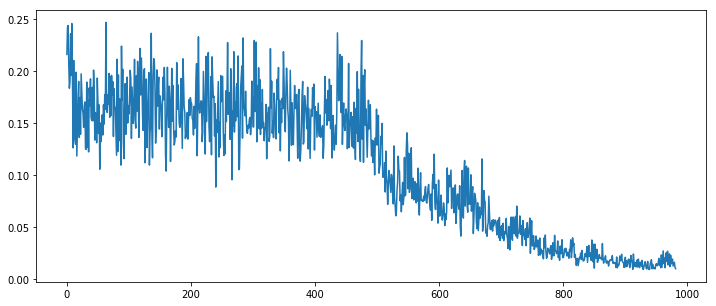

In [100]:
import matplotlib.pyplot as plt

# remove noise from initial epochs
loss_history_plot = list(filter(lambda x: x < 0.25, loss_history))

plt.figure(figsize=(12, 5))
plt.plot(loss_history_plot)
# plt.show()

In [104]:
if os.path.exists(CHECKPOINTS_DIR):
    path = CHECKPOINT_PATH
    
    model = JANet(inputs=2, cells=NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS)
    
    # load the weights
    model.load_state_dict(torch.load(path))
    
    model = model.to(device)
    
    loss = nn.MSELoss()
    
    # predict one batch to ensure the weights are correctly loaded
    generator = batch_generator()
    
    # dont compute gradients here
    with torch.no_grad():
        losses = []
        for i in range(20):
            inputs, outputs = next(generator)
            
            inputs = torch.from_numpy(inputs).to(device)
            outputs = torch.from_numpy(outputs).to(device)
    
            preds = model(inputs)
            loss_val = loss(outputs, preds)
    
            losses.append(loss_val.item())

    print("Final average predicted error (should be less than 0.03) : ", np.mean(losses))

Final average predicted error (should be less than 0.03) :  0.01556519940495491
